In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from IPython.display import display
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, silhouette_score, pairwise_distances
from sklearn.cluster import KMeans

In [2]:
def read_dataset(file_path, columns_opt=None, header_opt=None):
    dataset = pd.read_csv(file_path, header=header_opt, names=columns_opt)
    display(dataset.head())
    return dataset

def dataset_insights(dataset, label_column):
    display(dataset.describe())
    unique_classes = dataset[label_column].unique()
    print(f"\nClasses in dataset: {unique_classes}\n")
    print("Data Rows for each class:")
    for label in unique_classes:
        total_rows = len(dataset[dataset[label_column] == label])
        print(f"{total_rows} data rows for {label} class.")
    
def preprocess_dataset(dataset, label_column):
    dataset_columns = dataset.columns
    for column in dataset_columns:
        if column != label_column:
            dataset[column] = dataset[column] / dataset[column].max()
    
    display(dataset)
    return dataset

def plot_classes_chart(dataset, label_column):
    class_labels = dataset[label_column].unique()
    class_rows = {}
    for label in class_labels:
        class_rows[label] = len(dataset[dataset[label_column] == label])

    class_names = [name for name, _ in class_rows.items()]
    class_count = [count for _, count in class_rows.items()]

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.barh(class_names, class_count, color="darkorange")

    plt.xlabel("Number of Data Rows per Class")
    plt.ylabel("Class Name")
    ax.set_title("Number of Data for each Class in the Dataset")
    ax.set_yticks([0, 1, 2])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(color="grey", linestyle='-', linewidth=0.25, alpha=0.85)    

In [3]:
def getClassWithHighestDataRows(dataset, label_column):
    class_rows = {}
    for label in dataset[label_column].unique():
        class_rows[label] = len(dataset[dataset[label_column] == label])
    
    sorted_class_rows = sorted(class_rows.items(), key=lambda x:x[1], reverse=True)
    
    return sorted_class_rows[0]


def getDataRowsLength(class_with_most_data, imbalance_percentage, remaining_classes):
    new_dataset_total_rows = round((class_with_most_data[1] / imbalance_percentage) * 100)
    remaining_classes_percentage = 100 - imbalance_percentage
    remaining_classes_data = round(((new_dataset_total_rows / 100) * remaining_classes_percentage) / remaining_classes ) 
    
    return remaining_classes_data


def saveDataFrame(dataset, new_dataset, last_index, limit=None):
    dataset_columns = dataset.columns
    curr_index = last_index
    for _, data in dataset.iterrows():
        if curr_index <= (limit + last_index):
            for column in dataset_columns:
                new_dataset.at[curr_index, column] = data[column]

            curr_index += 1
     
    return new_dataset, curr_index


def createSubset(dataset, class_with_most_data, remaining_classes_rows, remaining_classes, label_column):
    new_dataset = pd.DataFrame(columns=dataset.columns)
    index = 0
    most_class_data = dataset[dataset[label_column] == class_with_most_data[0]]
    new_dataset, index = saveDataFrame(dataset, most_class_data, last_index=index, limit=class_with_most_data[1])
    
    for label in remaining_classes:
        dataset_class_data = dataset[dataset[label_column] == label]
        new_dataset, index = saveDataFrame(dataset_class_data, new_dataset, last_index=index, limit=remaining_classes_rows)
    
    return new_dataset

def getImbalanceSubset(dataset, label_column, imbalance_percentage):
    class_with_most_data = getClassWithHighestDataRows(dataset, label_column)
    remaining_classes = list(dataset[label_column].unique())
    remaining_classes.remove(class_with_most_data[0])
    
    remaining_classes_rows = getDataRowsLength(class_with_most_data, imbalance_percentage, len(remaining_classes))
    imbalance_dataset = createSubset(dataset, class_with_most_data, remaining_classes_rows, remaining_classes, label_column)
    
    dataset_insights(imbalance_dataset, label_column=label_column)
    
    return imbalance_dataset

In [4]:
# Yahan dataset read karna  ok 
#yahan pr uodate krna hey columns k name 
column_names = ["sepalLengthCm", "sepalWidthCm", "petalLengthCm", "pepalWidthCm", "class"] 
# Yeah hai read-dataset, dataset read ka function 
iris_dataset = read_dataset(file_path="iris.data", columns_opt=column_names)

,sepalLengthCm,sepalWidthCm,petalLengthCm,pepalWidthCm,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
# Dataset ki anlaysis ka function
dataset_insights(iris_dataset, label_column="class")

,sepalLengthCm,sepalWidthCm,petalLengthCm,pepalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000



Classes in dataset: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']

Data Rows for each class:
50 data rows for Iris-setosa class.
50 data rows for Iris-versicolor class.
50 data rows for Iris-virginica class.


In [6]:
# Dataset ki pre-processing
iris_dataset = preprocess_dataset(iris_dataset, label_column="class")

,sepalLengthCm,sepalWidthCm,petalLengthCm,pepalWidthCm,class
0,0.645570,0.795455,0.202899,0.08,Iris-setosa
1,0.620253,0.681818,0.202899,0.08,Iris-setosa
2,0.594937,0.727273,0.188406,0.08,Iris-setosa
3,0.582278,0.704545,0.217391,0.08,Iris-setosa
4,0.632911,0.818182,0.202899,0.08,Iris-setosa
...,...,...,...,...,...
145,0.848101,0.681818,0.753623,0.92,Iris-virginica
146,0.797468,0.568182,0.724638,0.76,Iris-virginica
147,0.822785,0.681818,0.753623,0.80,Iris-virginica
148,0.784810,0.772727,0.782609,0.92,Iris-virginica


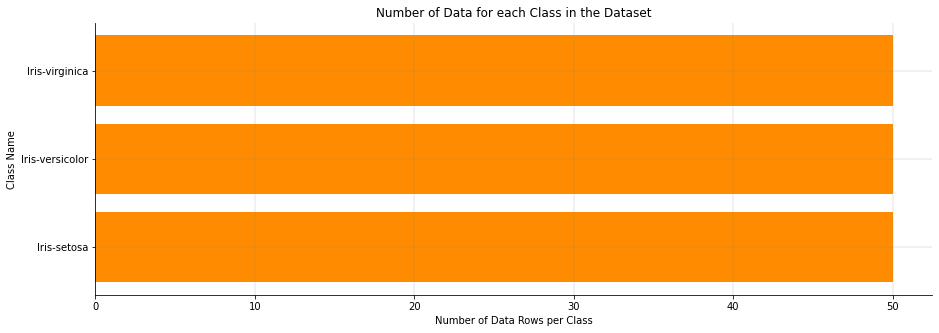

In [7]:
# Yeah function classes ko plot kkrny liye, ky class ki kitni entries hain
plot_classes_chart(iris_dataset, label_column="class")

In [8]:
# Yeah imbalance dataset ka function, ab last parameter imbalance_percentage, jitna imbalance dataset chaiye 
# uski percentage likh dena. jesy yahn 65, tu yeh low imbalance, agar 75 kar do gy tu mid imbalance hu jaye ga
iris_low_imb_dataset = getImbalanceSubset(iris_dataset, label_column="class", imbalance_percentage=65)

/tmp/ipykernel_5494/2839197389.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dataset.at[curr_index, column] = data[column]


,sepalLengthCm,sepalWidthCm,petalLengthCm,pepalWidthCm
count,79.000000,79.000000,79.000000,79.000000
mean,0.692838,0.729862,0.397358,0.307342
std,0.102028,0.105035,0.256052,0.296201
min,0.544304,0.454545,0.144928,0.040000
25%,0.620253,0.681818,0.202899,0.080000
50%,0.658228,0.727273,0.231884,0.120000
75%,0.753165,0.795455,0.659420,0.560000
max,0.962025,1.000000,0.956522,1.000000



Classes in dataset: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']

Data Rows for each class:
50 data rows for Iris-setosa class.
15 data rows for Iris-versicolor class.
14 data rows for Iris-virginica class.


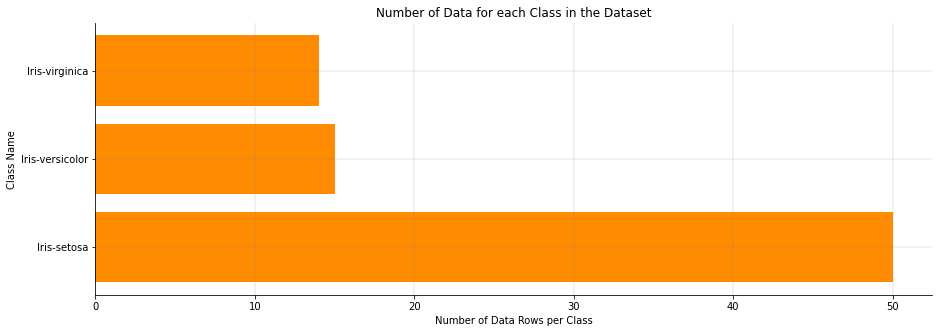

In [9]:
plot_classes_chart(iris_low_imb_dataset, label_column="class")

In [10]:
iris_mid_imb_dataset = getImbalanceSubset(iris_dataset, label_column="class", imbalance_percentage=75)

/tmp/ipykernel_5494/2839197389.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dataset.at[curr_index, column] = data[column]


,sepalLengthCm,sepalWidthCm,petalLengthCm,pepalWidthCm
count,69.000000,69.000000,69.000000,69.000000
mean,0.681710,0.744071,0.355598,0.254493
std,0.099819,0.097571,0.243648,0.270248
min,0.544304,0.522727,0.144928,0.040000
25%,0.620253,0.681818,0.202899,0.080000
50%,0.645570,0.727273,0.217391,0.120000
75%,0.721519,0.795455,0.579710,0.520000
max,0.962025,1.000000,0.956522,1.000000



Classes in dataset: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']

Data Rows for each class:
50 data rows for Iris-setosa class.
10 data rows for Iris-versicolor class.
9 data rows for Iris-virginica class.


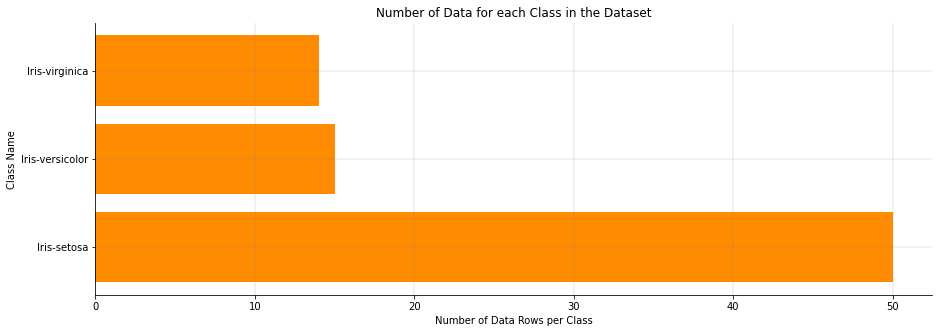

In [11]:
plot_classes_chart(iris_low_imb_dataset, label_column="class")

In [12]:
iris_high_imb_dataset = getImbalanceSubset(iris_dataset, label_column="class", imbalance_percentage=90)

/tmp/ipykernel_5494/2839197389.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dataset.at[curr_index, column] = data[column]


,sepalLengthCm,sepalWidthCm,petalLengthCm,pepalWidthCm
count,59.000000,59.000000,59.000000,59.000000
mean,0.662090,0.761941,0.291329,0.187119
std,0.083446,0.091140,0.192996,0.224369
min,0.544304,0.522727,0.144928,0.040000
25%,0.607595,0.704545,0.202899,0.080000
50%,0.645570,0.772727,0.217391,0.080000
75%,0.683544,0.806818,0.239130,0.160000
max,0.898734,1.000000,0.869565,1.000000



Classes in dataset: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']

Data Rows for each class:
50 data rows for Iris-setosa class.
5 data rows for Iris-versicolor class.
4 data rows for Iris-virginica class.


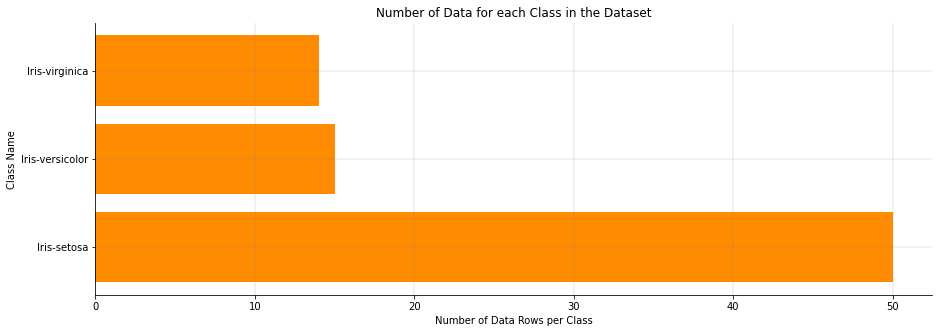

In [13]:
plot_classes_chart(iris_low_imb_dataset, label_column="class")

In [14]:
def getFeaturesLabels(dataset, label_column):
    return dataset.drop(label_column, axis=1), dataset[label_column]


def trainAndTestModelWithKFolds(classifier, cross_validator, features, labels):
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    
    for train_index, test_index in cross_validator.split(features, labels):
        classifier.fit(features.iloc[train_index], labels.iloc[train_index])

        actual_classes = np.append(actual_classes, labels.iloc[test_index])
        predicted_classes = np.append(predicted_classes, classifier.predict(features.iloc[test_index]))
    
    return actual_classes, predicted_classes

def computeAndPlotConfusionMatrix(actual_classes, predicted_classes, labels):
    matrix = confusion_matrix(actual_classes, predicted_classes, labels=labels)
    
    cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
    fig, ax = plt.subplots(figsize=(8,8))
    cm_display.plot(cmap=plt.cm.Blues, ax=ax)

In [15]:
# Step 2 cross validation or random forest ka
cross_validator = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
randomForestClassifier = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=6)
features, labels = getFeaturesLabels(iris_dataset, label_column="class")

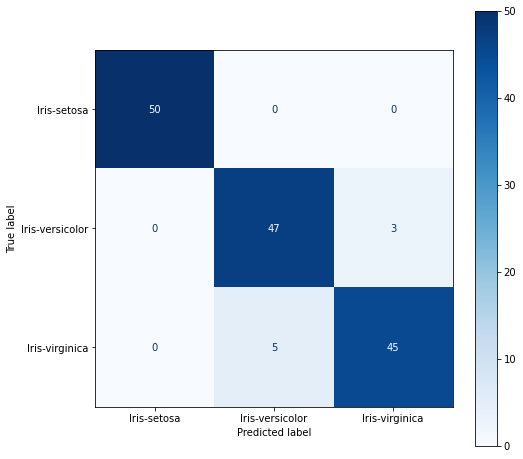

In [16]:
test_labels, pred_labels = trainAndTestModelWithKFolds(randomForestClassifier, cross_validator, features, labels)

computeAndPlotConfusionMatrix(test_labels, pred_labels, labels=iris_dataset["class"].unique())

In [32]:
def plotKData(metrics_info, technique=""):

    k_values = [k for k, _ in metrics_info.items()]
    k_scores = [score for _, score in metrics_info.items()]

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(k_values, k_scores, color="orangered", marker='o')

    plt.xlabel("No of Clusters")
    plt.ylabel("Score")
    ax.set_title(f"{technique} for finding best value of K")
    ax.set_xticks(k_values)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(color="grey", linestyle='-', linewidth=0.25, alpha=0.85)

In [40]:
def applyTechniquesOnKFoldsOfData(features, labels):
    cross_validator = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    
    unseen_fold_train_indexes = np.empty([0], dtype=int)
    unseen_fold_test_indexes = np.empty([0], dtype=int)
    train_fold_indexes = np.empty([0], dtype=int)
    test_fold_indexes = np.empty([0], dtype=int)
    
    kFold = 0
    for train_index, test_index in cross_validator.split(features, labels):
        if kFold == 0:
            unseen_fold_train_indexes = np.append(unseen_fold_train_indexes, train_index)
            unseen_fold_test_indexes = np.append(unseen_fold_test_indexes, test_index)
        else:
            train_fold_indexes = np.append(train_fold_indexes, train_index)
            test_fold_indexes = np.append(test_fold_indexes, test_index)
        
        kFold += 1
        
    
    return train_fold_indexes, test_fold_indexes, unseen_fold_train_indexes, unseen_fold_test_indexes

#             fold_features = features.iloc[train_index]
#             number_of_clusters = identifyNumberOfClusters(fold_features)
#             kmean_model = kMeanClusteringImplementation(number_of_clusters[0], fold_features)
            
#             for cluster in kmean_model.n_clusters:
# #                 if min_classes > 1:
# #                 trainRandomForestClassifier()
            
# #             last_fold_train_data = np.append(last_fold_train_data, train_index)
# #             last_fold_test_data = np.append(last_fold_test_data, test_index)
#             break

    
        
def MergeDataOfFolds():
    pass

def identifyNumberOfClusters(features):
    elbow_method_k = sorted(elbowMethodResult(features).items(), key=lambda x: x[1],reverse=False)
    
    return elbow_method_k[4]

def elbowMethodResult(features):
    k_metrices = {}
    for k in range(2, 11):
        kmean_classifier = KMeans(n_clusters=k).fit(features)
        k_metrices[k] = kmean_classifier.inertia_
    
    plotKData(k_metrices, technique="Elbow Method")
        

def avgSilhouteMethodResult(features):
    k_metrices = {}
    for k in range(2, 11):
        kmean_classifier = KMeans(n_clusters=k)
        kmean_cluster = kmean_classifier.fit_predict(features)
        avg_score = silhouette_score(features, kmean_cluster)
        
        k_metrices[k] = avg_score
    
    plotKData(k_metrices, technique="Silhoute Method")

def getClusterDetails():
    pass

def trainRandomForestClassifier():
    pass

def kMeanClusteringImplementation(k_clusters, features):
    kmean_classifier = KMeans(n_clusters=k_clusters)
    .fit(features)
    
    return kmean_classifier

# Create 10 folds for each of the dataset
# data of 9 folds: merge them
## Using the Elbow method and Silhoute Method Find the number of cluster in the dataset
## Run K-means according to the selected number of clusters
#### For each cluster identify: centroid, number of samples of minority class
#### Train rando forest for each cluster which contains more then 1 class


In [41]:
# Ab yeh sara step 3 or 4 hai isky nechy
train_fold_indexes, test_fold_indexes,\
unseen_fold_train_indexes, unseen_fold_test_indexes = applyTechniquesOnKFoldsOfData(features, labels)

In [42]:
train_features = features.iloc[train_fold_indexes]
train_labels = labels.iloc[train_fold_indexes]

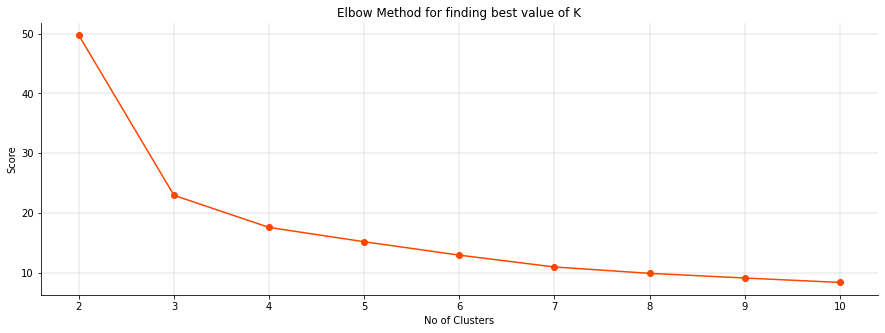

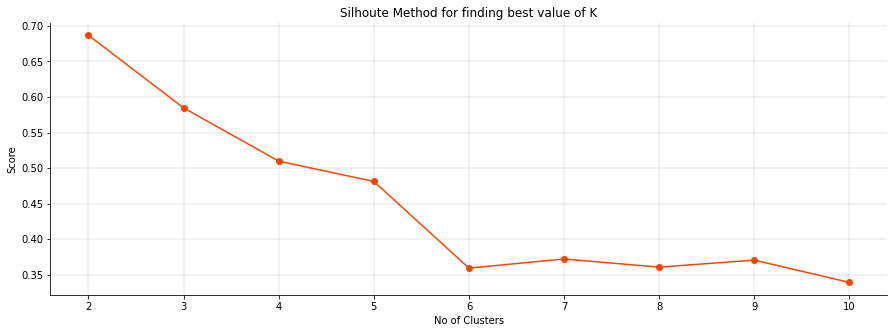

In [43]:
elbowMethodResult(train_features)
avgSilhouteMethodResult(train_features)

In [45]:
kmean_classifier_iris = KMeans(n_clusters=6)
iris_cluster_labels = kmean_classifier_iris.fit(train_features)

In [46]:
iris_cluster_labels.cluster_centers_

array([[0.66276465, 0.83447305, 0.21508272, 0.1139823 ],
       [0.78078251, 0.64566116, 0.743083  , 0.73090909],
       [0.70540258, 0.58505155, 0.56260272, 0.47072165],
       [0.87645791, 0.71020246, 0.84918676, 0.88244541],
       [0.59769465, 0.70492636, 0.20824225, 0.07642458],
       [0.79368888, 0.65952176, 0.67257367, 0.57516588]])

In [47]:
iris_cluster_labels.labels_

array([0, 4, 4, ..., 1, 3, 1], dtype=int32)

In [48]:
kmean_classifier_iris.fit_predict(train_features)

array([5, 0, 0, ..., 4, 2, 4], dtype=int32)

In [58]:
clusters_closets = pairwise_distances(iris_cluster_labels.cluster_centers_, train_features)

In [96]:
cluster_details = []
for cluster in range(iris_cluster_labels.n_clusters):
    cluster_detailed_info = {}
    data_indexes_in_cluster = []
    index = 0
    cluster_detailed_info["K"] = cluster + 1
    cluster_detailed_info["centroid"] = iris_cluster_labels.cluster_centers_[cluster]
    
    for point in clusters_closets[cluster]:
        if point <= 0.38:
            data_indexes_in_cluster.append(index)
        index += 1
#     print(data_indexes_in_cluster)

    #Unique Classes in cluster
    labels_data = train_labels.iloc[data_indexes_in_cluster]
    unique_classes = np.unique(labels_data)
    cluster_detailed_info["total_classes"] = unique_classes
    if len(unique_classes) > 1:
        labels_info = {}
        for label in unique_classes:
            labels_info[label] = len(labels_data[labels_data == label])
        labels_info = sorted(labels_info.items(), key=lambda x:x[1])
        cluster_detailed_info["minority_class"] = labels_info[0][0]
        cluster_detailed_info["minority_class_count"] = labels_info[0][1]
        
        features_data = train_features.iloc[data_indexes_in_cluster]
        
        classifier = tRandomForestCLassifier(features_data, labels_data)
        cluster_detailed_info["classifier"] = classifier
        
    else:
        cluster_detailed_info["minority_class"] = unique_classes[0]
        cluster_detailed_info["minority_class_count"] = len(labels_data)
        cluster_detailed_info["classifier"] = None
    
    cluster_details.append(cluster_detailed_info)

In [97]:
cluster_details

[{'K': 1,
  'centroid': array([0.59769465, 0.70492636, 0.20824225, 0.07642458]),
  'total_classes': array(['Iris-setosa'], dtype=object),
  'minority_class': 'Iris-setosa',
  'minority_class_count': 405,
  'classifier': None},
 {'K': 2,
  'centroid': array([0.79368888, 0.65952176, 0.67257367, 0.57516588]),
  'total_classes': array(['Iris-versicolor', 'Iris-virginica'], dtype=object),
  'minority_class': 'Iris-virginica',
  'minority_class_count': 291,
  'classifier': RandomForestClassifier(max_depth=6, n_estimators=10)},
 {'K': 3,
  'centroid': array([0.87645791, 0.71020246, 0.84918676, 0.88244541]),
  'total_classes': array(['Iris-versicolor', 'Iris-virginica'], dtype=object),
  'minority_class': 'Iris-versicolor',
  'minority_class_count': 105,
  'classifier': RandomForestClassifier(max_depth=6, n_estimators=10)},
 {'K': 4,
  'centroid': array([0.70540258, 0.58505155, 0.56260272, 0.47072165]),
  'total_classes': array(['Iris-versicolor', 'Iris-virginica'], dtype=object),
  'minority_

In [ ]:
for cluster in cluster_details:
    if len(cluster["total_classes"]) > 1:
        

In [95]:
def tRandomForestCLassifier(features, labels):
    classifier = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=6)
    return classifier.fit(features, labels)

In [98]:
unseen_fold_features = features.iloc[unseen_fold_train_indexes]
unseen_fold_labels = labels.iloc[unseen_fold_train_indexes]

In [115]:
predicted_labels = []
for feature in unseen_fold_features.to_numpy():
    cluster_distances = pairwise_distances(iris_cluster_labels.cluster_centers_, feature.reshape(1,-1))
    close_clusters = {}
    for cluster in range(len(cluster_distances)):
        if cluster_distances[cluster] <= 0.38:
            close_clusters[cluster] = cluster_distances[cluster]
            
    choosen_cluster = sorted(close_clusters.items(), key=lambda x:x[1])[0]
#     display(choosen_cluster)
#     display(cluster_details[choosen_cluster[0]])
    if len(cluster_details[choosen_cluster[0]]["total_classes"]) > 1:
        predicted_labels.append(cluster_details[choosen_cluster[0]]["classifier"].predict(feature.reshape(1,-1)))
    else:
        predicted_labels.append(cluster_details[choosen_cluster[0]]["minority_class"])
    

/home/abdulrehma/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/abdulrehma/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/abdulrehma/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/abdulrehma/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/abdulrehma/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/abdulrehm

/home/abdulrehma/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/abdulrehma/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/abdulrehma/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/abdulrehma/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/abdulrehma/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [116]:
predicted_labels

['Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 array(['Iris-versicolor'], dtype=object),
 array(['Iris-versicolor'], dtype=object),
 array(['Iris-versicolor'], dtype=object),
 array(['Iris-versicolor'], dtype=object),
 array(['Iris-versicolor'], dtype=object),
 array(['Iris-versicolor'], dtype=object),
 array(['Iris-versicol